## Kaggle NLP competition
https://www.kaggle.com/competitions/nlp-getting-started


<a id='TOC'/>

### TOC (table of content)
1. [Loading packages](#loading_packages)
2. [Loading data](#loading_data)
3. [Vectorizer](#vectorizer)
4. [Model](#model)
5. [Improvements](#improvements)
6. [Neural network](#neural_network)
7. [Decision tree classifier](#decision_tree)
8. [Random forest](#random_forest)
9. [KNN classifier](#knn)
10. [AdaBoost classifier](#adaboo)
11. [Stacking](#stacking)
12. [Voting](#voting)
13. [Conclusion](#conclusion)

<a id='loading_packages'/>

### Loading packages
[Back to TOC](#TOC)

In [169]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')


# Deep learning: 
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalAveragePooling1D, GlobalMaxPooling1D, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import io
import re
import string



from sklearn.tree import DecisionTreeClassifier, plot_tree

[nltk_data] Downloading package wordnet to /home/karol/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/karol/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


<a id='loading_data'/>

### Loading data
[Back to TOC](#TOC)

In [16]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df=df_train.copy()
print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB


### Let's have a look at the train and test dataset.

#### They contain:
- id
- keyword: A keyword from that tweet (although this may be blank!)
- location: The location the tweet was sent from (may also be blank)
- text: The text of a tweet
- target: 1 if the tweet is a real disaster or 0 if not

In [17]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [18]:
print(
    "The data contains {} actual disasters ({:.2%} of all data).".format(
        df[df.target == 1].shape[0],
        df[df.target == 1].shape[0] / df.shape[0],
    )
)

The data contains 3271 actual disasters (42.97% of all data).


In [19]:
print(
    "Examples of actual disaster tweet: \n    {}\n    {}".format(
        df[df.target == 1].sample(1).text.iloc[0],
        df[df.target == 1].sample(1).text.iloc[0],
    )
)
print(
    "\nExamples of a tweet with no disaster behind it: \n    {}\n    {}".format(
        df[df.target == 0].sample(1).text.iloc[0],
        df[df.target == 0].sample(1).text.iloc[0],
    )
)

Examples of actual disaster tweet: 
    Refugio oil spill may have been costlier bigger than projected http://t.co/xcoLwUGFjg
    Investigators say a fatal Virgin Galactic spaceship crash last year was caused by structural failure after the coÛ_

Examples of a tweet with no disaster behind it: 
    wreck? wreck wreck wreck wreck wreck wreck wreck wreck wreck wreck wreck wreck?
    I liked a @YouTube video http://t.co/5fR41TPzte Thorin's Thoughts - Riot and Sandbox Mode (LoL)


<a id='vectorizer'/>

### Vectorizer
[Back to TOC](#TOC)

In [173]:
X_train, X_test, y_train, y_test = train_test_split(df_train["text"], df_train["target"], random_state=777,test_size=0.2, stratify=df_train["target"])



X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, random_state=777, test_size=0.2, stratify=y_train)


In [174]:
print(
    "Length of train set: {}\n Length of test set: {}\n".format(len(X_train), len(X_val))
)



Length of train set: 4872
 Length of test set: 1218



### Transform the text so that each word is a separate feature and count how many times that word occurs. (Save as a sparse matrix.)

In [175]:
# Fit the CountVectorizer to the training data
vect = CountVectorizer().fit(X_train)

# transform the text in the training data to a text-term matrix
X_train_vectorized = vect.transform(X_train)

vect

CountVectorizer()

### Vocabulary sample:

In [176]:
sorted(vect.vocabulary_.items())[4000:4010]

[('delivers', 4000),
 ('dell', 4001),
 ('delmont', 4002),
 ('delta', 4003),
 ('deluded', 4004),
 ('deluge', 4005),
 ('deluged', 4006),
 ('delusion', 4007),
 ('deluxe', 4008),
 ('dem', 4009)]

In [177]:
full_vocab_len=len(vect.vocabulary_)

print(
    "The training data contains {} different words (columns) across {} messages (rows).".format( 
                                                            len(vect.vocabulary_.items()),
                                                            X_train.shape[0]
                                                           )
     )

The training data contains 15759 different words (columns) across 4872 messages (rows).


### Show the (sparse) feature matrix:

In [178]:
X_train_vectorized.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

<a id='model'/>

### Model
[Back to TOC](#TOC)

### Let's train a logistic regression model with the train data

In [179]:
log_reg_model = LogisticRegression(max_iter=777)
log_reg_model.fit(X_train_vectorized, y_train)

# Predict the transformed validation texts
predictions = log_reg_model.predict(vect.transform(X_test))
predict_probab = log_reg_model.predict_proba(vect.transform(X_test))[:,1]

print("Accuracy = {:.5f}".format(accuracy_score(y_test, predictions)))
print("AUC = {:.3f}".format(roc_auc_score(y_test, predict_probab)))

Accuracy = 0.79317
AUC = 0.837


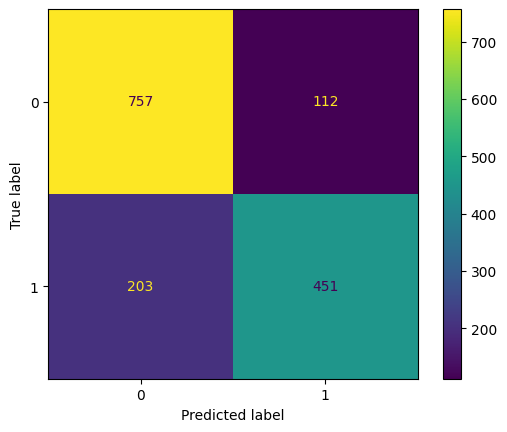

In [180]:
confusion_matrix_model = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
confusion_matrix_model.plot()

### Let's check which words are most probably associated with actual disasters and which are not.

In [183]:
# list of words (features)
feature_names = np.array(vect.get_feature_names_out())

#list of corresponding coefficients
sorted_coef_index = log_reg_model.coef_[0].argsort()

print("Words with the smallest Coefficients (i.e. not indicative of a real disaster):\n{}\n".format(feature_names[sorted_coef_index[:20]]))
print("Words with the largest Coefficients (i.e. very indicative of a real disaster): \n{}".format(feature_names[sorted_coef_index[:-21:-1]]))

Words with the smallest Coefficients (i.e. not indicative of a real disaster):
['full' 'song' 'new' 'panic' 'ebay' 'sure' 'let' 'ass' 'obliteration'
 'bags' 'poll' 'blight' 'collide' 'cake' 'ruin' 'flattened' 'head' 'lmao'
 'nowplaying' 'upheaval']

Words with the largest Coefficients (i.e. very indicative of a real disaster): 
['hiroshima' 'storm' 'earthquake' 'fires' 'wildfire' 'california' 'shot'
 'train' 'typhoon' 'volcano' 'floods' 'drought' 'bombing' 'hurricane'
 'evacuated' 'spill' 'casualties' 'forest' 'suicide' 'plane']


<a id='improvements'/>

### Improvements
[Back to TOC](#TOC)

### Let's try to improve our prediction by considering term frequency using TF-IDF 

In [184]:
#Consider only words that occur in at least 3 tweets.
vect = TfidfVectorizer(min_df=3).fit(X_train)


X_train_vectorized = vect.transform(X_train)

# let's look of some of the words gathered with this method
sorted(vect.vocabulary_.items())[150:160]

[('age', 150),
 ('ago', 151),
 ('agree', 152),
 ('agreed', 153),
 ('ah', 154),
 ('ahead', 155),
 ('aid', 156),
 ('aim', 157),
 ('ain', 158),
 ('air', 159)]

In [185]:
print(
    "The training data now contains {} different words (columns) across {} messages (rows).".format( 
                                                            len(vect.vocabulary_.items()),
                                                            X_train.shape[0]
                                                           )
     )

The training data now contains 3214 different words (columns) across 4872 messages (rows).


In [186]:
# list of words (features)
feature_names = np.array(vect.get_feature_names_out())

#list of corresponding tfidf values
sorted_tfidf_index = X_train_vectorized.toarray().max(0).argsort()

# print words with highest and lowest tfidf values
print("Smallest tfidf:\n{}\n".format(feature_names[sorted_tfidf_index[:20]]))
print("Largest tfidf: \n{}".format(feature_names[sorted_tfidf_index[:-21:-1]]))

Smallest tfidf:
['ksawlyux02' 'sh' 'utc2015' 'time2015' 'sm' 'destiny' 'enemy' 'blessings'
 'curved' '300w' '53inch' 'offroad' 'arwx' 'eq' 'disea' 'realise'
 'prebreak' '18w' '2pcs' 'handbag']

Largest tfidf: 
['hurricane' 'on' 'mudslide' 'girl' 'sinking' 'meltdown' 'twister'
 'flattened' 'flames' 'no' 'emergency' 'fatality' 'traumatised' 'wreck'
 'trauma' 'weapon' 'weapons' 'survive' 'obliterated' 'thanks']


In [187]:
log_reg_model_TF_IDF = LogisticRegression(max_iter=777)
log_reg_model_TF_IDF.fit(X_train_vectorized, y_train)

# Predict the transformed validation texts
predictions = log_reg_model_TF_IDF.predict(vect.transform(X_test))
predict_probab = log_reg_model_TF_IDF.predict_proba(vect.transform(X_test))[:,1]

print("Accuracy = {:.5f}".format(accuracy_score(y_test, predictions)))
print("AUC = {:.3f}".format(roc_auc_score(y_test, predict_probab)))

Accuracy = 0.79054
AUC = 0.841


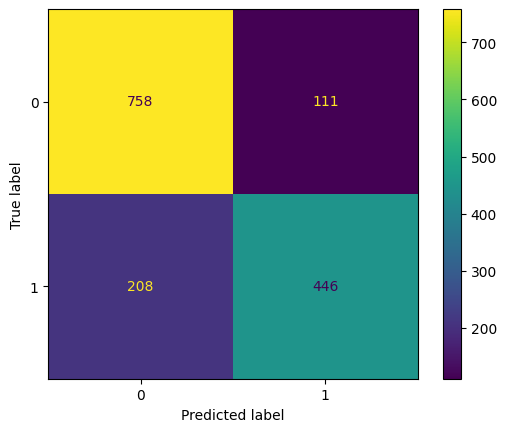

In [188]:
confusion_matrix_model = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
confusion_matrix_model.plot()

In [189]:
# list of words (features)
feature_names = np.array(vect.get_feature_names_out())

#list of corresponding coefficients
sorted_coef_index = log_reg_model_TF_IDF.coef_[0].argsort()

print("Words with the smallest Coefficients (i.e. not indicative of a real disaster):\n{}\n".format(feature_names[sorted_coef_index[:20]]))
print("Words with the largest Coefficients (i.e. very indicative of a real disaster): \n{}".format(feature_names[sorted_coef_index[:-21:-1]]))

Words with the smallest Coefficients (i.e. not indicative of a real disaster):
['you' 'new' 'full' 'my' 'let' 'youtube' 'body' 'panic' 'or' 'bags' 'he'
 'ebay' 'blight' 'song' 'obliteration' 'ruin' 'flattened' 'collide'
 'demolish' 'me']

Words with the largest Coefficients (i.e. very indicative of a real disaster): 
['hiroshima' 'in' 'california' 'fires' 'storm' 'train' 'killed' 'wildfire'
 'bombing' 'earthquake' 'fire' 'suicide' 'buildings' 'typhoon' 'disaster'
 'forest' 'japan' 'evacuated' 'car' 'accident']


### Using TF-IDF, we have increased our AUC score slightly. But we have lost a few true negatives.

### Let's make the texts more comparable by using stemming.

In [190]:
stemmer = nltk.PorterStemmer()
cv_analyzer = TfidfVectorizer(min_df=2).build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in cv_analyzer(doc))

stem_vectorizer = TfidfVectorizer(min_df=2, analyzer = stemmed_words)
X_train_stem_vectorized = stem_vectorizer.fit_transform(X_train)

In [193]:
log_reg_model_stem = LogisticRegression(max_iter=777)
log_reg_model_stem.fit(X_train_stem_vectorized, y_train)

# Predict the transformed validation texts
predictions = log_reg_model_stem.predict(stem_vectorizer.transform(X_test))
predict_probab = log_reg_model_stem.predict_proba(stem_vectorizer.transform(X_test))[:,1]

print("Accuracy = {:.5f}".format(accuracy_score(y_test, predictions)))
print("AUC = {:.3f}".format(roc_auc_score(y_test, predict_probab)))

Accuracy = 0.78858
AUC = 0.847


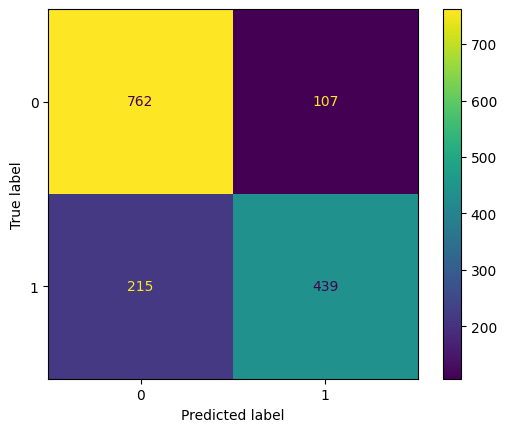

In [194]:
confusion_matrix_model = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
confusion_matrix_model.plot()

### Stemming further increases the AUC. But now we have lost a few true positives. What about Lemmatization?

In [195]:
WNlemma = nltk.WordNetLemmatizer()
cv_analyzer = TfidfVectorizer(min_df=4).build_analyzer()


def lemmatize_word(doc):
    return (WNlemma.lemmatize(t) for t in cv_analyzer(doc))

lemm_vectorizer = TfidfVectorizer(min_df=4, analyzer = lemmatize_word)


X_train_lemm_vectorized = lemm_vectorizer.fit_transform(X_train)

In [196]:
log_reg_model_lemm = LogisticRegression(max_iter=777)
log_reg_model_lemm.fit(X_train_lemm_vectorized, y_train)

# Predict the transformed validation texts
predictions = log_reg_model_lemm.predict(lemm_vectorizer.transform(X_test))
predict_probab = log_reg_model_lemm.predict_proba(lemm_vectorizer.transform(X_test))[:,1]

print("Accuracy = {:.5f}".format(accuracy_score(y_test, predictions)))
print("AUC = {:.3f}".format(roc_auc_score(y_test, predict_probab)))

Accuracy = 0.78267
AUC = 0.843


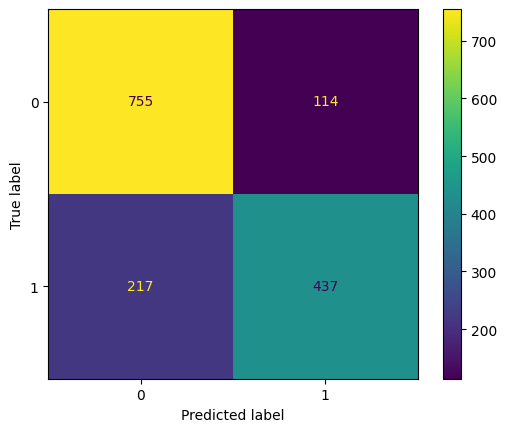

In [197]:
confusion_matrix_model = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
confusion_matrix_model.plot()

### Nope. Lemmatization yields the worst results yet.

### Next, let's test a neural network.

<a id='neural_network'/>

### Neural network
[Back to TOC](#TOC)

In [71]:

print('train size:', len(y_train))

print('test size:', len(y_test))

print('val size:', len(y_val))


# convert datasets for use in Keras


dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

dataframe_train=pd.concat([X_train,y_train], axis=1)
dataframe_test=pd.concat([X_test,y_test], axis=1)

# create batches of the datasets for training, validation and testing

batch_size=500
dataset_train_batch = dataset_train.batch(batch_size=batch_size)
dataset_val_batch = dataset_val.batch(batch_size=batch_size)
dataset_test_batch = dataset_test.batch(batch_size=batch_size)

train size: 4872
test size: 1523
val size: 1218


Define Vecorizer

In [72]:
def custom_standardization(input_data):
    """Text preprocessing: lowercases, no punctuation

    Args:
        input_data (tf.dataframe): [text, formated as tf.string]

    Returns:
        [tf.dataframe]: [preprocessed text]
    """
    text_lower = tf.strings.lower(input_data)
    return tf.strings.regex_replace(text_lower, '[%s]' % re.escape(string.punctuation), '')

# get the number of words in each message
sequence_len = int(dataframe_train.text.apply(lambda x: len(x.split())).max()) 

# define the text vectorization layer 
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=full_vocab_len,
    output_mode='int',
    output_sequence_length=sequence_len)

# Make a text-only dataset (without labels)
train_text = dataset_train.map(lambda x, y: x)
vectorize_layer.adapt(train_text)


In [73]:
print("1138 ---> ",vectorize_layer.get_vocabulary()[1138])
print(" 327 ---> ",vectorize_layer.get_vocabulary()[327])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1138 --->  terror
 327 --->  survivors
Vocabulary size: 15759


### Define the model. Note that it uses word embeddings.

In [74]:
tf.keras.backend.clear_session()

embedding_dim=3
model_nn = Sequential([
  vectorize_layer,
  Embedding(full_vocab_len, embedding_dim, name="embedding"),
  GlobalAveragePooling1D(),
  Dropout(0.5),
  Dense(500, activation='relu'),
  Dropout(0.25),
#  Dense(16, activation='elu'),
  Dense(1, activation='sigmoid')
])

model_nn.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['AUC'])


In [75]:
# training the model




early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=20,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)



model_nn.fit(
    dataset_train_batch,
    validation_data=dataset_val_batch,
    epochs=100,
    callbacks=[early_stopping_monitor]
    )


Epoch 1/100
10/10 [==============================] - 2s 48ms/step - loss: 0.6887 - auc: 0.5035 - val_loss: 0.6843 - val_auc: 0.5009
Epoch 2/100
10/10 [==============================] - 0s 23ms/step - loss: 0.6833 - auc: 0.5093 - val_loss: 0.6827 - val_auc: 0.5768
Epoch 3/100
10/10 [==============================] - 0s 31ms/step - loss: 0.6828 - auc: 0.5387 - val_loss: 0.6820 - val_auc: 0.6151
Epoch 4/100
10/10 [==============================] - 0s 28ms/step - loss: 0.6813 - auc: 0.5772 - val_loss: 0.6806 - val_auc: 0.6727
Epoch 5/100
10/10 [==============================] - 0s 28ms/step - loss: 0.6797 - auc: 0.6060 - val_loss: 0.6785 - val_auc: 0.7185
Epoch 6/100
10/10 [==============================] - 0s 19ms/step - loss: 0.6758 - auc: 0.6625 - val_loss: 0.6752 - val_auc: 0.7524
Epoch 7/100
10/10 [==============================] - 0s 18ms/step - loss: 0.6723 - auc: 0.6748 - val_loss: 0.6701 - val_auc: 0.7806
Epoch 8/100
10/10 [==============================] - 0s 29ms/step - loss: 0.

In [76]:
# calculating the loss and accuracy on the test set.
loss, accuracy = model_nn.evaluate(dataset_val_batch, verbose=2)

3/3 - 0s - loss: 0.4485 - auc: 0.8682 - 28ms/epoch - 9ms/step


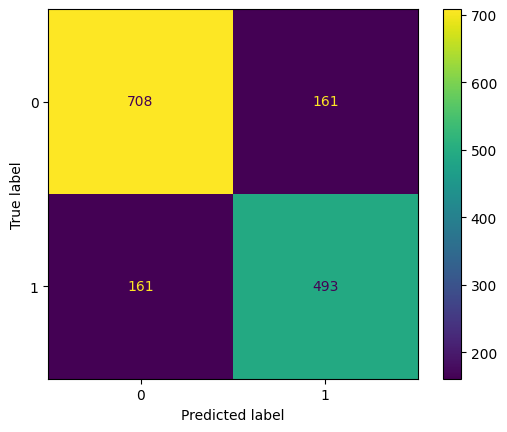

In [77]:
y_test_pred_classes = (
    pd.DataFrame(model_nn.predict(tf.data.Dataset.from_tensor_slices((X_test)).batch(batch_size=batch_size), verbose=0)
    .flatten())
    .applymap(lambda x: 1 if x>0.5 else 0)
    .rename(columns={0:'pred'})
)
confusion_matrix_model = ConfusionMatrixDisplay(confusion_matrix(np.array(dataframe_test.target), np.array(y_test_pred_classes.pred)))
confusion_matrix_model.plot()

### We have lost a significant amount of true negatives but gained an even higher amount of true positives.

<a id='decision_tree'/>

## Decision tree classifier
[Back to TOC](#TOC)

In [201]:
stemmer = nltk.PorterStemmer()
cv_analyzer = TfidfVectorizer(min_df=2).build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in cv_analyzer(doc))

vect = TfidfVectorizer(min_df=2, analyzer = stemmed_words)

# transform the text in the training data to a text-term matrix
X_train_vectorized = vect.fit_transform(X_train)
X_test_vectorized = vect.transform(X_test)
X_val_vectorized = vect.transform(X_val)

In [216]:
tree_model = DecisionTreeClassifier(
        criterion = "gini", 
        max_depth = 70, min_samples_leaf = 7) 




# train 
tree_model.fit(X_train_vectorized, y_train) 

DecisionTreeClassifier(max_depth=70, min_samples_leaf=7)

Accuracy = 0.68089
AUC = 0.709


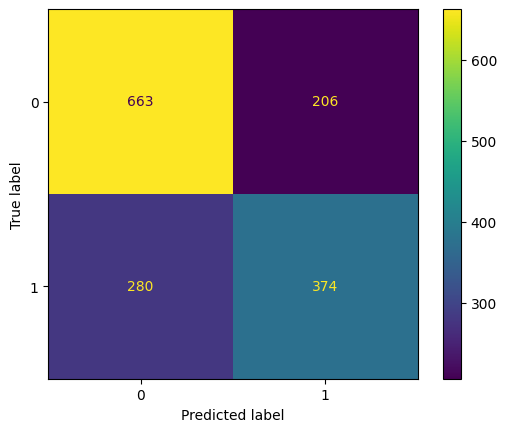

In [217]:
predictions = tree_model.predict(X_test_vectorized)
predict_probab = tree_model.predict_proba(X_test_vectorized)[:,1]

print("Accuracy = {:.5f}".format(accuracy_score(y_test, predictions)))
print("AUC = {:.3f}".format(roc_auc_score(y_test, predict_probab)))


confusion_matrix_model = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
confusion_matrix_model.plot()


### This is by far the worst model. The true negatives are quite high but the true positives are underestimated.

<a id='random_forest'/>

## Random Forest
[Back to TOC](#TOC)

In [218]:
# Create the model with 100 trees
random_forest_model = RandomForestClassifier(n_estimators=300, 
                               random_state=777, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 0)

# train 
random_forest_model.fit(X_train_vectorized, y_train) 



RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=777)

Accuracy = 0.77741
AUC = 0.827


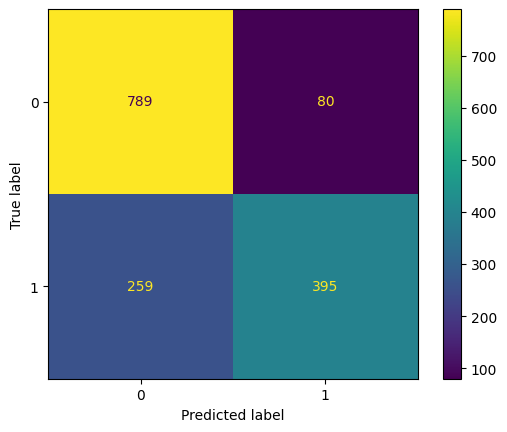

In [219]:
predictions = random_forest_model.predict(X_test_vectorized)
predict_probab = random_forest_model.predict_proba(X_test_vectorized)[:,1]

print("Accuracy = {:.5f}".format(accuracy_score(y_test, predictions)))
print("AUC = {:.3f}".format(roc_auc_score(y_test, predict_probab)))


confusion_matrix_model = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
confusion_matrix_model.plot()


In [220]:
print("Train set Accuracy = {:.5f}".format(accuracy_score(y_train, random_forest_model.predict(vect.transform(X_train)))))
print("Train set AUC = {:.3f}".format(roc_auc_score(y_train, random_forest_model.predict_proba(vect.transform(X_train))[:,1])))


Train set Accuracy = 0.98768
Train set AUC = 0.999


### We see that the random forest classifier is overfitting the training set, however, it yields its best AUC score on the test set while it is of overfitting.

<a id='knn'/>

## KNN classifier
[Back to TOC](#TOC)

In [221]:
knn_model = KNeighborsClassifier(n_neighbors=7, metric='cosine')


# train 
knn_model.fit(X_train_vectorized, y_train) #np.ravel(y_train)?

KNeighborsClassifier(metric='cosine', n_neighbors=7)

Accuracy = 0.76822
AUC = 0.803


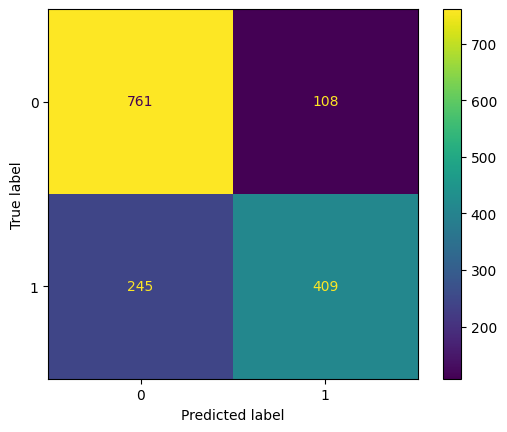

In [222]:
predictions = knn_model.predict(X_test_vectorized)
predict_probab = knn_model.predict_proba(X_test_vectorized)[:,1]

print("Accuracy = {:.5f}".format(accuracy_score(y_test, predictions)))
print("AUC = {:.3f}".format(roc_auc_score(y_test, predict_probab)))


confusion_matrix_model = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
confusion_matrix_model.plot()


<a id='adaboo'/>

## AdaBoost classifier
[Back to TOC](#TOC)

In [224]:
adaboo_model = AdaBoostClassifier(random_state=777)
adaboo_model.fit(X_train_vectorized, y_train)


AdaBoostClassifier(random_state=777)

Accuracy = 0.75181
AUC = 0.799


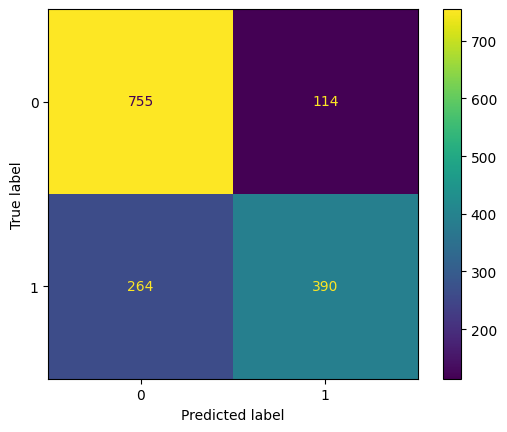

In [225]:
predictions = adaboo_model.predict(X_test_vectorized)
predict_probab = adaboo_model.predict_proba(X_test_vectorized)[:,1]

print("Accuracy = {:.5f}".format(accuracy_score(y_test, predictions)))
print("AUC = {:.3f}".format(roc_auc_score(y_test, predict_probab)))


confusion_matrix_model = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
confusion_matrix_model.plot()


<a id='stacking'/>

## Lets try stacking! Yey!
[Back to TOC](#TOC)

In [243]:
estimators = [
    ('log_reg_model', log_reg_model),
    #('tree_model', tree_model),
    ('random_forest_model', random_forest_model),
    #('knn_model', knn_model),
    ('adaboo_model',adaboo_model)
]

stacking_model = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression())
stacking_model.fit(X_train_vectorized, y_train)#.score(X_test, y_test)



StackingClassifier(estimators=[('log_reg_model',
                                LogisticRegression(max_iter=777)),
                               ('random_forest_model',
                                RandomForestClassifier(n_estimators=300,
                                                       n_jobs=-1,
                                                       random_state=777)),
                               ('adaboo_model',
                                AdaBoostClassifier(random_state=777))],
                   final_estimator=LogisticRegression())

Accuracy = 0.78792
AUC = 0.849


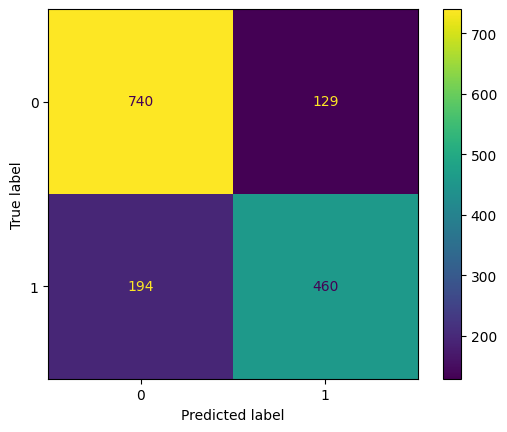

In [247]:
predictions = stacking_model.predict(vect.transform(X_test))
predict_probab = stacking_model.predict_proba(vect.transform(X_test))[:,1]

print("Accuracy = {:.5f}".format(accuracy_score(y_test, predictions)))
print("AUC = {:.3f}".format(roc_auc_score(y_test, predict_probab)))


confusion_matrix_model = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
confusion_matrix_model.plot()


<a id='voting'/>

## And a voting method
[Back to TOC](#TOC)

In [248]:
voting_model = VotingClassifier(estimators = estimators, voting = 'hard')
voting_model.fit(X_train_vectorized, y_train)

VotingClassifier(estimators=[('log_reg_model',
                              LogisticRegression(max_iter=777)),
                             ('random_forest_model',
                              RandomForestClassifier(n_estimators=300,
                                                     n_jobs=-1,
                                                     random_state=777)),
                             ('adaboo_model',
                              AdaBoostClassifier(random_state=777))])

Accuracy = 0.78726


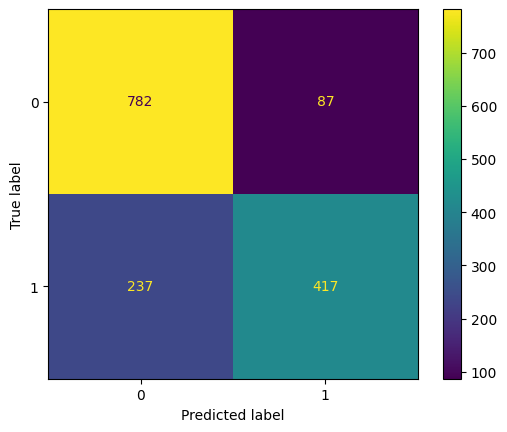

In [249]:
predictions = voting_model.predict(vect.transform(X_test))
#predict_probab = voting_model.predict_proba(vect.transform(X_test))[:,1]

print("Accuracy = {:.5f}".format(accuracy_score(y_test, predictions)))
#print("AUC = {:.3f}".format(roc_auc_score(y_test, predict_probab)))


confusion_matrix_model = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
confusion_matrix_model.plot()


<a id='conclusion'/>

## Conclusion:
[Back to TOC](#TOC)

#### The highest AUC was achieved (for now) after stacking a Logistic Regression model, Random Forest, and Adaboost. It seems to yield the best balance between true negatives and true positives.